In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['tsla_24jul.html', 'amzn_24jul.html', 'fb_24jul.html', 'goog_24jul.html', 'tsla_26nov.html', 'tsla_22sep.html', 'fb_05ene.html', 'tsla_05ene.html', 'fb_22sep.html']


Trying to perdict the price of a certain stock has always been a challenging problem. This kernel tries to preict the behavior of a stock from news headlines. The stock price and related news for any trading company can be taken from [FINVIZ](http://finviz.com). 
I have used [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) for the analysis. 'Beautiful Soup is a python library for pulling data out of HTML and XML files.'

In [2]:
# Import libraries
from bs4 import BeautifulSoup
import pandas as pd
import os

html_pages = {}

# The dataset includes webpages from different days for different companies.
for page_name in os.listdir('../input'):
    page_path = f'../input/{page_name}'
    page_file = open(page_path, 'r')
    html_data = BeautifulSoup(page_file)
    # The .html file contains a 'news-table' section that holds all the news headlines
    html_page = html_data.find(id="news-table")
    # Add the page to our dictionary
    html_pages[page_name] = html_page

You can display the html pages that we have extracted so far.

In [3]:
html_pages

{'tsla_24jul.html': <table border="0" cellpadding="1" cellspacing="0" class="fullview-news-outer" id="news-table" width="100%">
 <tbody><tr><td align="right" style="white-space:nowrap" width="130">Jul-24-19 02:01PM  </td><td align="left"><a class="tab-link-news" href="https://www.investors.com/news/ford-earnings-q2-2019-ford-stock-buy-point/?src=A00220&amp;yptr=yahoo" target="_blank">Ford Stock Nears Buy Point Ahead Of Earnings Due After The Close</a> <span style="color:#aa6dc0;font-size:9px">Investor's Business Daily</span></td></tr>
 <tr><td align="right" width="130">12:12PM  </td><td align="left"><a class="tab-link-news" href="https://www.marketwatch.com/story/atts-video-business-is-decaying-and-a-new-streaming-service-may-not-save-it-2019-07-24?siteid=yhoof2&amp;yptr=yahoo" target="_blank">AT&amp;Ts video business is decaying and a new streaming service may not save it</a> <span style="color:#aa6dc0;font-size:9px">MarketWatch</span></td></tr>
 <tr><td align="right" width="130">11:5

Now we can explore the material of these headlines. What's inside them!
You may want to check these links for a better understanding of the elements of a HTML page.

[a: The Anchor element](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/a)

[td: The Table Data Cell element](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/td)

In [4]:
amzn = html_pages['amzn_24jul.html']
# All the headlines in the .html file are stored as table rows and are tagged as <tr>
amzn_tr = amzn.findAll('tr') #Remember this is a beautiful soup now. So, we can directly find <tr> tag.

for i, tr in enumerate(amzn_tr):
    # <a> in these .html pages contain the news headlines.
    hyperlinks = tr.a.get_text()
    # <td> in these .html page contain the time stamp.
    headlines = tr.td.get_text()
    print(f'{i}:')
    print(hyperlinks)
    print(headlines)
    
    #if i == 5:
    #    break

0:
Morgan Stanley: Disney Earnings Could Nearly Double In Five Years
Jul-24-19 02:30PM  
1:
Alibaba Opens Its Doors to U.S. Merchants to Widen Its Moat
02:15PM  
2:
UPS stock soars toward best gain in a decade after profit beat, outlook held firm
02:04PM  
3:
EBay to launch warehousing and shipping services next year
01:39PM  
4:
UPDATE 1-EBay to launch warehousing and shipping services next year
01:34PM  
5:
Facebook and Other Big Tech Stocks Are Barely Moving on the DoJs New Probe. Heres Why.
01:34PM  
6:
Antitrust Probe Likely to Hit These Tech ETFs
01:00PM  
7:
Feds Bite Apple, FANG Stocks, But They Have A Lot To Chew On
12:52PM  
8:
The most intimate data youre giving up may not be to Facebook, Amazon or Apple
12:52PM  
9:
Facebook (FB) Earnings After The Bell: Can The Growth Continue?
12:19PM  
10:
EBay to launch warehousing and shipping service next year
11:58AM  
11:
GRAPHIC-Taking stock: Swiss franc intervention seeps far and wide
11:39AM  
12:
Mnuchin lays into Amazon, says i

Let's try the same with all the webpages in the dataset.

In [5]:
news = []

for page_name, news_table in html_pages.items():
    for x in news_table.findAll('tr'):
        text = x.get_text()
        headline = x.a.get_text()
        # Split date-time, because some elements just have time, while others have time and date as well.
        date_td = x.td.text.split()
        # If only time
        if len(date_td) == 1:
            time = date_td[0]
        # If both time and Date
        else:
            date = date_td[0]
            time = date_td[1]
        # Separate the stock symbol    
        stock_symbol = page_name.split('_')[0]
        # Join everything
        news.append([stock_symbol, date, time, headline])
        
news[:5] # print first five news headlines

[['tsla',
  'Jul-24-19',
  '02:01PM',
  'Ford Stock Nears Buy Point Ahead Of Earnings Due After The Close'],
 ['tsla',
  'Jul-24-19',
  '12:12PM',
  'AT&Ts video business is decaying and a new streaming service may not save it'],
 ['tsla',
  'Jul-24-19',
  '11:53AM',
  'GM Delays Robotaxi Service As Autonomous Vehicles Stall'],
 ['tsla',
  'Jul-24-19',
  '10:30AM',
  'Ahead Of Earnings, Analysts Are Divided On Tesla'],
 ['tsla',
  'Jul-24-19',
  '10:17AM',
  'A Tesla Bears Guide to Getting Bullish on Its Stock After Earnings']]

I have used VADER to perform sentiment analysis, because it doesn't require any training data. 
We can add new words to the VADER Lexicon text file which are specific to our problem. In our case, since we are working with stock market, adding words like 'falls', 'trouble', etc. with an associated positive or negative score should be good practice. 

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100
}

analyser = SentimentIntensityAnalyzer()

analyser.lexicon.update(new_words)

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Now we have updated the lexicons in the VADER model, we can try to evaluate the polarity of the news headlines.

In [7]:
columns = ['stock_symbol', 'date', 'time', 'headline']
# Load list of the news into a pandas DataFrame
news_headlines = pd.DataFrame(news, columns = columns)
# Go through each headline and evaluate it's polarity. 
senti_scores = [analyser.polarity_scores(headline) for headline in news_headlines.headline.values]
# Convert it into a DataFrame for easy joining.
sentiment = pd.DataFrame(senti_scores)
# Join headline and its sentiment score.
news_headlines = pd.concat([news_headlines, sentiment], axis = 1)
# Date column is converted from string to datetime
news_headlines['date'] = pd.to_datetime(news_headlines.date).dt.date
news_headlines.head(10)

,stock_symbol,date,time,headline,compound,neg,neu,pos
0,tsla,2019-07-24,02:01PM,Ford Stock Nears Buy Point Ahead Of Earnings D...,0.0000,0.000,1.000,0.000
1,tsla,2019-07-24,12:12PM,AT&Ts video business is decaying and a new str...,-0.6517,0.326,0.674,0.000
2,tsla,2019-07-24,11:53AM,GM Delays Robotaxi Service As Autonomous Vehic...,-0.2023,0.205,0.795,0.000
3,tsla,2019-07-24,10:30AM,"Ahead Of Earnings, Analysts Are Divided On Tesla",0.0000,0.000,1.000,0.000
4,tsla,2019-07-24,10:17AM,A Tesla Bears Guide to Getting Bullish on Its ...,0.0000,0.000,1.000,0.000
5,tsla,2019-07-24,09:43AM,GM Cruise Delays Robotaxi Debut in Latest Driv...,0.0000,0.000,1.000,0.000
6,tsla,2019-07-24,09:38AM,Tesla Gets Ready To Report After Upside Surpri...,0.5574,0.000,0.685,0.315
7,tsla,2019-07-24,09:25AM,Tesla Stock's Sharp Rise From Its Lows Makes f...,-0.3182,0.248,0.752,0.000
8,tsla,2019-07-24,07:35AM,Tesla Reports Earnings Today: Is it all Gloomy...,-0.1531,0.151,0.849,0.000
9,tsla,2019-07-24,07:30AM,"At Tesla, another quarterly loss is likely, bu...",0.5423,0.167,0.542,0.291


Try to plot the sentiment scores

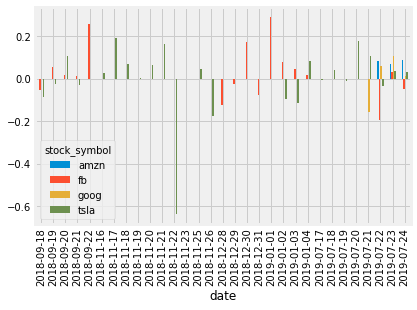

In [8]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline
# Group by Date and Company
mean_c = news_headlines.groupby(['date', 'stock_symbol']).mean()

mean_c = mean_c.unstack(level=1)
mean_c = mean_c.xs('compound', axis=1)

mean_c.plot.bar();

Seems like Tesla had some trouble on November 22. Further exploration reveals that there were only 5 headlines on that day. And 2 of them were almost similar.
We can further check and try to remove similar headlines from the dataset.

In [9]:
# Number of news headlines
dirty_news = news_headlines.headline.count()
# Drop duplicates headlines
cleaned_news = news_headlines.drop_duplicates(['stock_symbol', 'headline'])
# Number of headlines after dropping 
clean_news = cleaned_news.headline.count()

print(dirty_news)
print(clean_news)

900
871


To finish the project, lets try to explore just one stock on any given day (just a single day), cause this is what one should be interested in.
And don't forget to use 'cleaned_news'.

In [10]:
single_day = cleaned_news.set_index(['stock_symbol', 'date'])
single_day = single_day.loc['amzn']

# Set day to January of 2019
single_day = single_day.loc['2019-07-24']

# Convert the datetime string to just the time since it is just one day.
single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time

# Set the index to time and sort by it
single_day.set_index('time', inplace=True)
single_day=single_day.sort_index(ascending=True)
single_day.head()

,headline,compound,neg,neu,pos
time,,,,,
00:15:00,PRESS DIGEST - Wall Street Journal - July 24,0.0000,0.0,1.000,0.000
00:28:00,"Video Ad Push, User Growth to Aid Facebook's (...",0.3818,0.0,0.794,0.206
02:45:00,Stocks - U.S. Futures Fall As DoJ Launches Pro...,0.0000,0.0,1.000,0.000
05:15:00,Amazon Is Set to Report Earnings Tomorrow. Her...,0.1779,0.0,0.855,0.145
05:51:00,T+2 to Vaudeville!,0.0000,0.0,1.000,0.000


We can now visualize the sentiment scores using a plot.

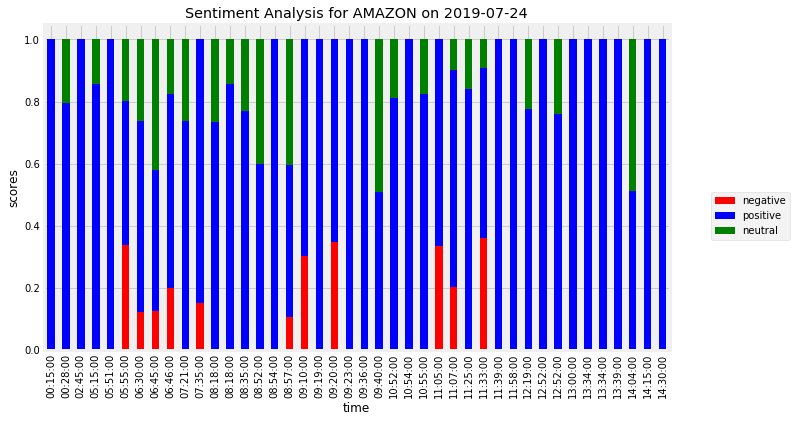

In [11]:
# Drop the columns which are useless
plot_day = single_day.drop(['headline', 'compound'], axis=1)
# Give names to the sentiments
plot_day.columns = ['negative', 'positive', 'neutral']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = "Sentiment Analysis for AMAZON on 2019-07-24", 
                  color = ["red", "blue", "green"])
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");

Seems like news regarding Amazon were mostly 'positive' or 'neutral' on July 24, 2019. 
Let's check the stock price for the same day.
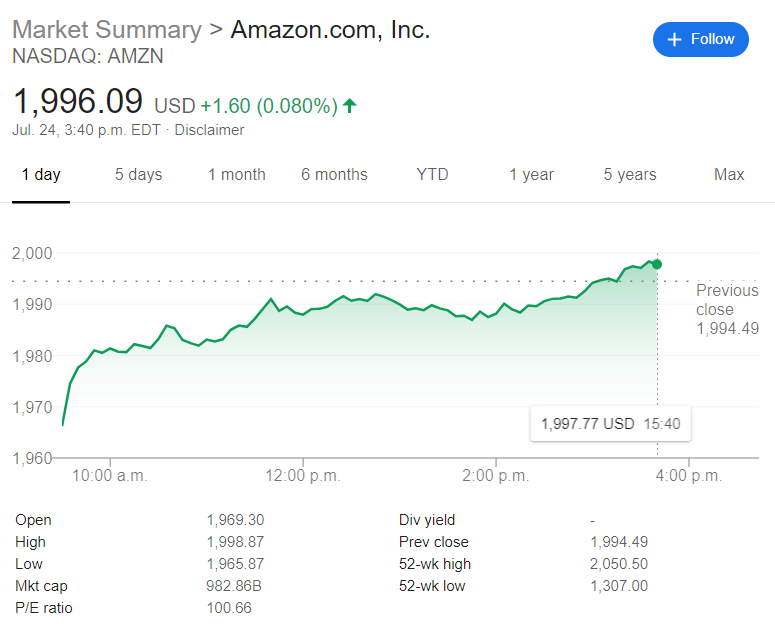